In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import torch.utils.data as Data

In [2]:
ds = pd.read_csv('../../data/mnist.csv').values
print ds.shape

(42000, 785)


In [3]:
# Data Preparation
X_train = ds[:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = ds[5000:5100, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_test = ds[5000:5100, 0]
# y_train = one_hot(y_train_labels, 10)

print X_train.shape, y_train.shape

(10000, 1, 28, 28) (10000,)


In [15]:
nn.ConvTranspose2d?

In [16]:
class CAE(torch.nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.enc_linear = nn.Linear(8*2*2, 2)
        
        self.dec_linear = nn.Linear(2, 8*2*2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )
    
    def encoding(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.enc_linear(x)
        return x
    
    def decoding(self, x):
        x = self.dec_linear(x)
        x = x.view(x.size(0), 8, 2, 2)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encoding(x)
        x = self.decoding(x)
        return x

In [33]:
model = CAE().cuda()

In [34]:
# model(torch.FloatTensor(X_train[:1])).min()

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_func = nn.MSELoss()

In [36]:
def make_batch(train, labels, batch_size=10, gpu=True):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        if gpu:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.FloatTensor(train[start:stop])).cuda()
        else:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.LongTensor(train[start:stop])).cuda()
        start = stop
        stop = start + batch_size

In [37]:
for epoch in range(500):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 256)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = model(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in model.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if epoch % 10 == 0 and step %200 == 0:
            test_output = model(torch.FloatTensor(X_test).cuda())
            test_loss = loss_func(test_output, torch.FloatTensor(X_test).cuda())
            acc = test_loss.cpu().data.numpy()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

('Epoch: ', 0, '| Step: ', 0, '| Acc: ', array(0.21532743, dtype=float32))
('Epoch: ', 10, '| Step: ', 0, '| Acc: ', array(0.05604114, dtype=float32))
('Epoch: ', 20, '| Step: ', 0, '| Acc: ', array(0.05243701, dtype=float32))
('Epoch: ', 30, '| Step: ', 0, '| Acc: ', array(0.05042791, dtype=float32))
('Epoch: ', 40, '| Step: ', 0, '| Acc: ', array(0.0490901, dtype=float32))
('Epoch: ', 50, '| Step: ', 0, '| Acc: ', array(0.04834052, dtype=float32))
('Epoch: ', 60, '| Step: ', 0, '| Acc: ', array(0.04821775, dtype=float32))
('Epoch: ', 70, '| Step: ', 0, '| Acc: ', array(0.04783975, dtype=float32))
('Epoch: ', 80, '| Step: ', 0, '| Acc: ', array(0.04765055, dtype=float32))
('Epoch: ', 90, '| Step: ', 0, '| Acc: ', array(0.04710865, dtype=float32))
('Epoch: ', 100, '| Step: ', 0, '| Acc: ', array(0.04716108, dtype=float32))
('Epoch: ', 110, '| Step: ', 0, '| Acc: ', array(0.04707479, dtype=float32))
('Epoch: ', 120, '| Step: ', 0, '| Acc: ', array(0.04693317, dtype=float32))
('Epoch: ',

In [38]:
model.cpu()
# model.cuda()

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_linear): Linear(in_features=32, out_features=2, bias=True)
  (dec_linear): Linear(in_features=2, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [40]:
o = model(torch.FloatTensor(X_train[:4000])).data.numpy()

emb = model.encoding(torch.FloatTensor(X_train[:4000])).data.numpy()

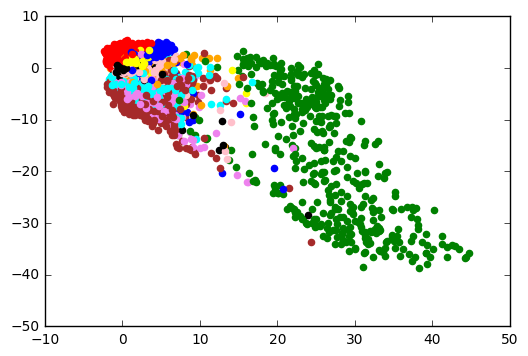

In [41]:
colors = ['red', 'green', 'blue', 'black', 'cyan', 'orange', 'yellow', 'brown', 'pink', 'violet']

for ix in range(emb.shape[0]):
    plt.scatter(emb[ix, 0], emb[ix, 1], color=colors[y_train[ix]])
plt.show()

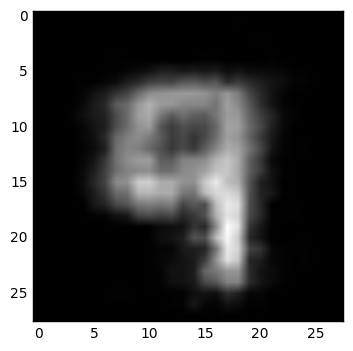

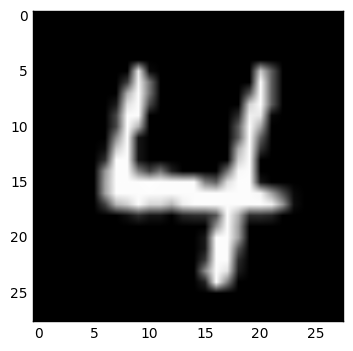

In [27]:
plt.figure(0)
plt.imshow(o[42].reshape((28, 28)), cmap='gray')

plt.figure(1)
plt.imshow(X_train[42].reshape((28, 28)), cmap='gray')